In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image
 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

2024-05-03 14:37:18,559 - notebook_logger - INFO - Image ID:, 163939
2024-05-03 14:37:18,560 - notebook_logger - INFO - **************************************************
2024-05-03 14:37:18,560 - notebook_logger - INFO - Categories: ['tv', 'dining table', 'cup', 'keyboard', 'spoon', 'book']
2024-05-03 14:37:18,561 - notebook_logger - INFO - Super Categories: ['electronic', 'furniture', 'kitchen', 'indoor']
2024-05-03 14:37:18,561 - notebook_logger - INFO - **************************************************
2024-05-03 14:37:18,561 - notebook_logger - INFO - Q:what color are the noodles
A:white
Q:is the noodles in liquid
A:yes
Q:is the cup big
A:medium
Q:does the cup have a handle
A:yes
Q:is the computer on
A:i think so
Q:what color is the computer
A:i can only see the bottom of the screen and the keyboard, so silver
Q:is the computer a laptop
A:nope
Q:is there a person
A:nope
Q:is there a chair
A:can't see that much of the scene
Q:is there a desk
A:yes

2024-05-03 14:37:18,561 - notebo

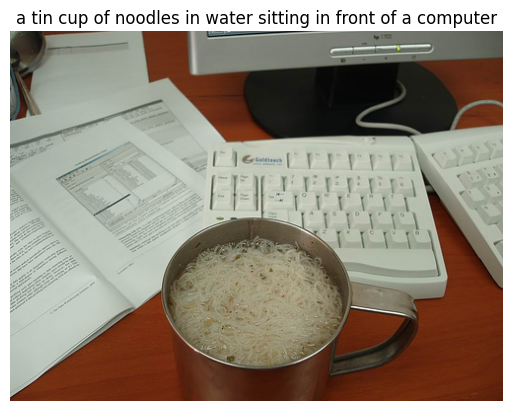

2024-05-03 14:37:18,915 - notebook_logger - INFO - person CLIP feature similarity: 0.21572211384773254
2024-05-03 14:37:18,945 - notebook_logger - INFO - animal CLIP feature similarity: 0.20924411714076996
2024-05-03 14:37:18,976 - notebook_logger - INFO - vehicle CLIP feature similarity: 0.1851411908864975
2024-05-03 14:37:19,007 - notebook_logger - INFO - outdoor CLIP feature similarity: 0.18118084967136383
2024-05-03 14:37:19,038 - notebook_logger - INFO - accessory CLIP feature similarity: 0.22066977620124817
2024-05-03 14:37:19,069 - notebook_logger - INFO - sports CLIP feature similarity: 0.21964167058467865
2024-05-03 14:37:19,100 - notebook_logger - INFO - kitchen CLIP feature similarity: 0.23414503037929535
2024-05-03 14:37:19,131 - notebook_logger - INFO - food CLIP feature similarity: 0.2552574872970581
2024-05-03 14:37:19,161 - notebook_logger - INFO - furniture CLIP feature similarity: 0.20848242938518524
2024-05-03 14:37:19,193 - notebook_logger - INFO - electronic CLIP f

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

In [5]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
#df_table['OOD'] = df_table['supercategories'].apply(lambda x: 1 if any(item in x for item in ood_category) else 0)
df_table['OOD'].value_counts()

OOD
0    16461
1      519
Name: count, dtype: int64

In [6]:
## Dialogue Processing
dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
df_table['dialogue_clip'] = list(dialogue_clip)

## Image Processing
image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
image_annotation.rename(columns={0:"image_clip"}, inplace=True)
df_table = df_table.merge(image_annotation, on='img_file', how='left')

In [7]:
dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [9]:
df_table.columns

Index(['dialog', 'score', 'dialog_dataset', 'dialog_file', 'img_dataset',
       'img_file', 'set_source', 'image_id', 'image_idx', 'categories',
       'supercategories', 'OOD', 'dialogue_clip', 'image_clip',
       'encoded_label', 'person', 'animal', 'outdoor', 'accessory', 'sports',
       'kitchen', 'food', 'furniture', 'electronic', 'appliance', 'indoor'],
      dtype='object')

In [12]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

if data_loader.data_source == "qa":
    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += np.exp(10*cosine_sim_current)
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)

    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))

  0%|          | 0/16980 [00:00<?, ?it/s]

In [13]:
dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))

  0%|          | 0/61810 [00:00<?, ?it/s]

In [14]:
df_table['dialogue_score_segement'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
df_table['dialogue_score_segement_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

In [15]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/16980 [00:00<?, ?it/s]

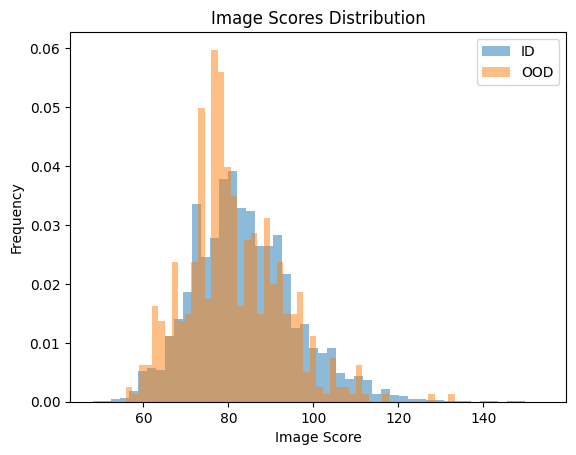

In [19]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = True)
plt.legend(loc='upper right')
plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')
plt.show()

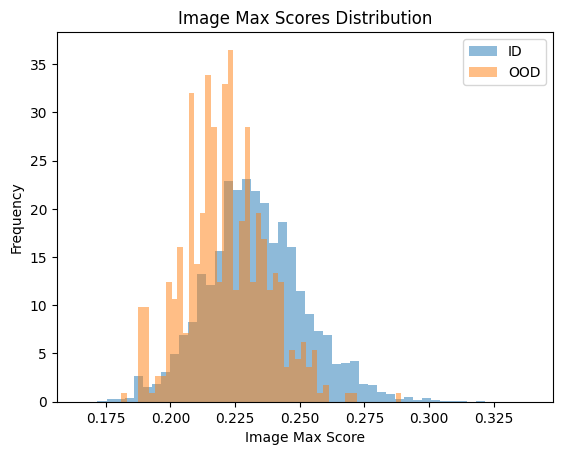

In [20]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score_max']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = True)
plt.legend(loc='upper right')
plt.title('Image Max Scores Distribution')
plt.xlabel('Image Max Score')
plt.ylabel('Frequency')
plt.show()

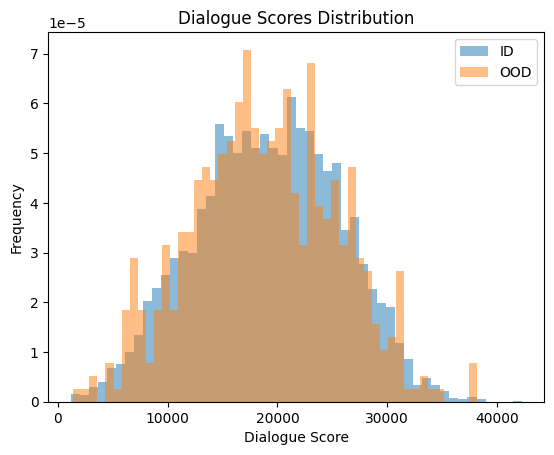

In [21]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = True)
plt.legend(loc='upper right')
plt.title('Dialogue Scores Distribution')
plt.xlabel('Dialogue Score')
plt.ylabel('Frequency')
plt.show()

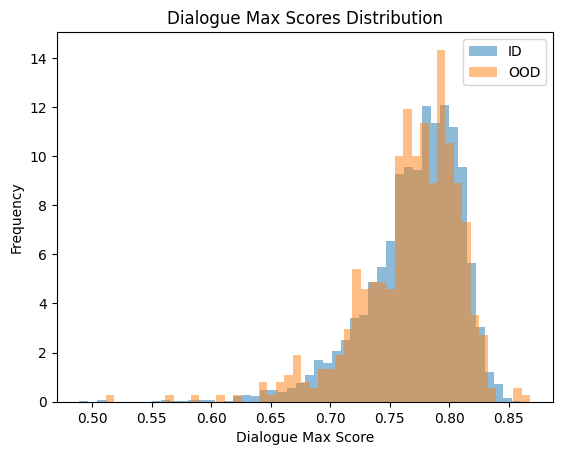

In [22]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score_max']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = True)
plt.legend(loc='upper right')
plt.title('Dialogue Max Scores Distribution')
plt.xlabel('Dialogue Max Score')
plt.ylabel('Frequency')
plt.show()

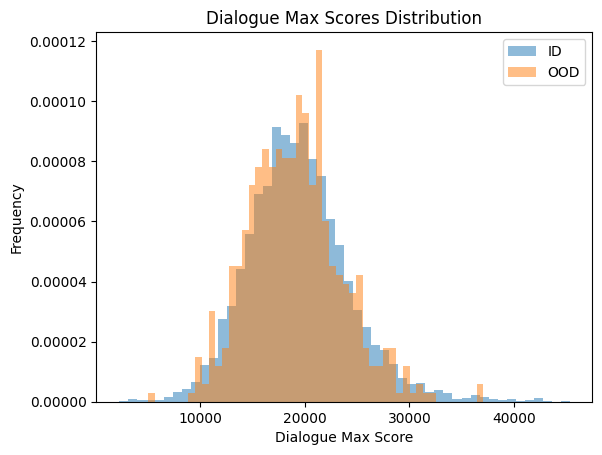

In [23]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score_segement']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score_segement']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density=True)
plt.legend(loc='upper right')
plt.title('Dialogue Max Scores Distribution')
plt.xlabel('Dialogue Max Score')
plt.ylabel('Frequency')
plt.show()

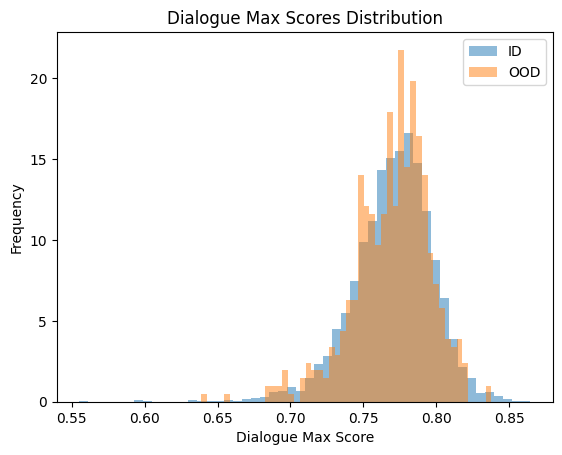

In [24]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score_segement_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score_segement_max']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density=True)
plt.legend(loc='upper right')
plt.title('Dialogue Max Scores Distribution')
plt.xlabel('Dialogue Max Score')
plt.ylabel('Frequency')
plt.show()

In [25]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from '/Users/xuetongwu/Documents/GitHub/multimodal_ood/utils/evaluation.py'>

In [40]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score_max'] + df_table['dialogue_score_max'])

In [41]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score'].values, 0.95))
print('Dialogue Segment:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segement'].values, 0.95))
print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segement_max'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity'].values, 0.95))

Image Max: 0.8246157584593888
Image Sum: 0.903711803657129
Dialogue Max: 0.9461150598384059
Dialogue Sum: 0.9502460360852925
Dialogue Segment: 0.9351193730636049
Dialogue Segment Max: 0.9387036024542859
Overall Max: 0.8709677419354839


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

from models.DNN import model 

model_loader = model.model_loader(logger=logger,
                                  num_epochs=15)

2024-05-03 14:29:08,871 - notebook_logger - INFO - Setting random seed: 42


In [46]:
df_ind_train['OOD'].value_counts()

OOD
0    13169
Name: count, dtype: int64

In [47]:
df_test['OOD'].value_counts()

OOD
0    3292
1     519
Name: count, dtype: int64

In [48]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = model_loader.create_dataset(data_loader, df_table)


In [49]:
model_loader.train_model(X_train_image, Y_train)

100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


In [50]:
score_sum, score_max = model_loader.evaluate_on_test(X_test_image, 
                                                    Y_test,
                                                    return_score=True)

2024-05-03 14:31:38,184 - notebook_logger - INFO - Test Loss: 0.1689, Test Accuracy: 0.7251


In [51]:
df_test['energy_sum_image'] = score_sum
df_test['energy_max_image'] = score_max

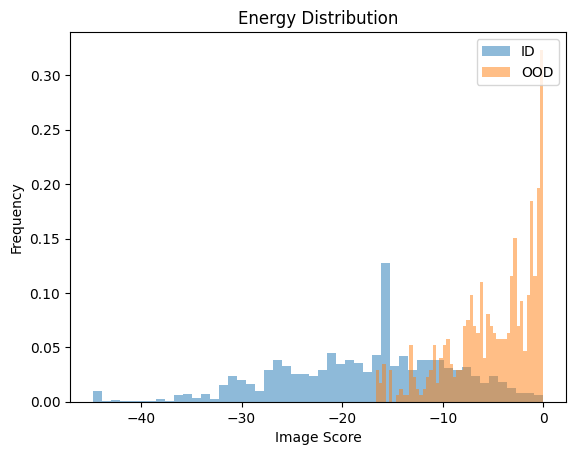

In [53]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_sum_image']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_sum_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD',density=True)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

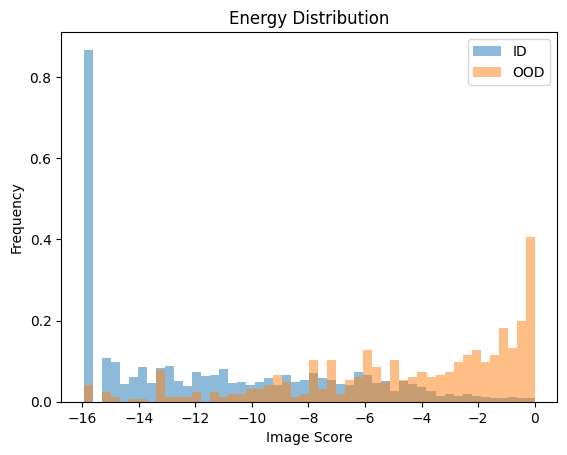

In [55]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_max_image']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_max_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID',density=True)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density=True) 
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [56]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum_image'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max_image'].values, 0.95))

2024-05-03 14:33:09,458 - notebook_logger - INFO - 0.3068043742405832
2024-05-03 14:33:09,459 - notebook_logger - INFO - 0.56318347509113


In [57]:
model_loader.train_model(X_train_dialogue, Y_train)

100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


In [58]:
score_sum, score_max = model_loader.evaluate_on_test(X_test_dialogue, 
                                                    Y_test,
                                                    return_score=True)

2024-05-03 14:33:50,460 - notebook_logger - INFO - Test Loss: 0.4400, Test Accuracy: 0.1033


In [59]:
df_test['energy_sum_dialogue'] = score_sum
df_test['energy_max_dialogue'] = score_max

In [60]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum_dialogue'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max_dialogue'].values, 0.95))

2024-05-03 14:34:06,572 - notebook_logger - INFO - 0.9629404617253949
2024-05-03 14:34:06,573 - notebook_logger - INFO - 0.9620291616038882
